参考了https://github.com/brenttsss/numerical-analysis

In [2]:
import numpy as np
from scipy.integrate import odeint
from scipy.linalg import solve, norm
import matplotlib.pyplot as plt

考虑边值问题
\begin{equation}
\frac{d^2 \phi}{dr^2} + \frac{1}{r}\frac{d\phi}{dr} - \phi + 2\phi^3 = 0
\end{equation}
with boundary conditions
\begin{equation}
\frac{d\phi}{dr}\left. \right|_{r=0}=0,\quad \phi \left. \right|_{r=\infty}=0.
\end{equation}
这个方程等价于粒子 $\phi$ 在势能 $V(\phi)$ 上的运动：
$$
\frac{d^2 \phi}{dr^2} + \frac{1}{r}\frac{d\phi}{dr} = \phi - 2\phi^3 = -\frac{\partial V}{\partial \phi}
$$

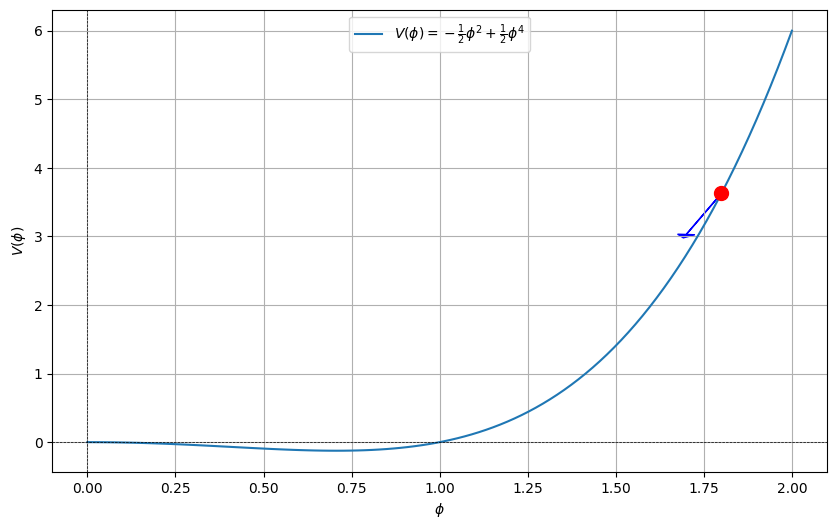

In [30]:
# 定义函数 V(φ)
def V(phi):
    return -1/2 * phi**2 + 1/2 * phi**4

# 生成数据
x = np.linspace(0, 2, 100)
y = V(x)

# 创建图形
plt.figure(figsize=(10, 6))
plt.plot(x, y, label=r'$V(\phi) = -\frac{1}{2}\phi^2 + \frac{1}{2}\phi^4$')

# 在 x=2 附近添加小球和箭头
ball_x = 1.8
ball_y = V(ball_x)

# 绘制小球
plt.plot(ball_x, ball_y, 'ro', markersize=10) 

# 绘制箭头标记方向
arrow_start_x = ball_x
arrow_start_y = V(arrow_start_x)
plt.arrow(arrow_start_x, arrow_start_y, -0.1, -0.6, 
          head_width=0.05, head_length=0.05, fc='blue', ec='blue')

# 设置标签和标题
plt.xlabel(r'$\phi$')
plt.ylabel(r'$V(\phi)$')
plt.axhline(0, color='black', linewidth=0.5, ls='--')
plt.axvline(0, color='black', linewidth=0.5, ls='--')
plt.grid()
plt.legend()
plt.show()

因此我们可以使用打靶法：不断调整粒子在 $V$ 上的初始位置，直到它正好停在 $\phi=0$ 处。

In [17]:
a, b = [0.01, 10]
N = 100
h = (b - a)/N
r = np.linspace(a, b, N+1)

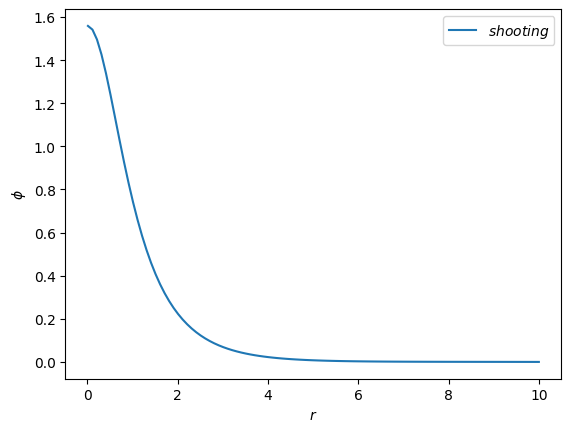

In [18]:
def f(v, r):
    return v[1], -(1/r)*v[1] + v[0] - 2*v[0]**3


vstart, vend = [1.5, 2]
tol = 10**(-6)
diff = np.abs(vend - vstart)
updated_v = 0

while diff > tol:
    updated_v = (vstart + vend)/2
    v0 = [updated_v, 0]
    v = odeint(f, v0, r)

    if v[-1][0] < 0:
        vend = updated_v
    elif v[-1][0] > 0:
        vstart = updated_v

    diff = np.abs(vend - vstart)

v0 = [updated_v, 0]
v_shooting = odeint(f, v0, r)
v1 = v_shooting[:,0]

plt.plot(r, v1, label=r'$shooting$')
plt.xlabel(r'$r$')
plt.ylabel(r'$\phi$')
plt.legend()
plt.show()

接下来我们采用 newton_kantorovich 方法。首先对 $\phi$ 加一个微扰项，$\phi \rightarrow \phi + \delta \phi$。然后对微分方程做 quasi-linearization, 即只保留扰动的一阶项。

$$
\frac{d^2 (\phi+\delta \phi)}{dr^2} + \frac{1}{r}\frac{d(\phi+\delta \phi)}{dr} - (\phi+\delta \phi) + 2(\phi+\delta \phi)^3 = 0
$$

于是有

\begin{equation}
\begin{cases}
\left[\frac{d^2}{dr^2} + \frac{1}{r} \frac{d}{dr} - 1 + 6\phi ^2\right]\delta \phi = - \left[ \frac{d^2 \phi }{dr^2} + \frac{1}{r}\frac{d\phi}{dr} - \phi + 2\phi^3\right]\\
\delta \phi'(0) = -\phi'(0)\\
\delta \phi(\infty) = -\phi(\infty)
\end{cases}
\end{equation}

我们用有限差分的方法做离散化。选取 $h$ 为空间步长，
\begin{equation}
h=\frac{b-a}{N}
\end{equation}
所以有 $N + 1$ 个点以及 $N$ 个间隔。 

除此之外，我们还需要选择一个初始的试探解，这里我们选择 $e^{-r^2}$。

将中心、前向、后向差分代入 Newton-Kantorovich 方程
\begin{align}
\frac{\delta\phi_{j-1} - 2\delta\phi_j + \delta\phi_{j+1}}{h^2} + \frac{1}{r}\frac{\delta\phi_{j+1} - \delta\phi_{j-1}}{2h}-\delta\phi_j + 6v_j^2 \delta\phi_j &= \frac{\phi_{j-1}-2\phi_j+\phi_{j+1}}{h^2} - \frac{1}{r}\frac{\phi_{j+1} - \phi_{j-1}}{2h} + \phi_j - 2\phi_{j}^3\\
\frac{-3\delta\phi_1 + 4\delta\phi_2 - \delta\phi_3}{2h} &= -\frac{-3\phi_1 + 4\phi_2 - \phi_3}{2h}\\
\delta\phi_{N+1} &= -\phi_{N+1}
\end{align}

Expressing the left hand side in terms of $z$ of the new system
\begin{align}
\delta\phi_j\left(-\frac{2}{h^2} - 1 + 6v_j^2\right) + \delta\phi_{j-1}\left(\frac{1}{h^2} - \frac{1}{r}\frac{1}{2h}\right)+\delta\phi_{j+1}\left(\frac{1}{h^2} + \frac{1}{r}\frac{1}{2h}\right) &= -\frac{\phi_{j-1}-2v_j+\phi_{j+1}}{h^2} - \frac{1}{r}\frac{\phi_{j+1} - \phi_{j-1}}{2h} + \phi_j - 2\phi_{j}^3 \\
\delta\phi_1\left(-\frac{3}{2h}\right) + \delta\phi_2(2h) + \delta\phi_3\left(-\frac{1}{2h}\right)&=-\frac{-3\phi_1 + 4\phi_2 - \phi_3}{2h}\\
\delta\phi_{N+1} &= -\phi_{N+1}
\end{align}


The system can be expressed as
\begin{equation}
\begin{pmatrix}
-\frac{3}{2h} & 2h & -\frac{1}{2h} & & \cdots & 0\\
\frac{1}{h^2}-\frac{1}{r}\frac{1}{2h} & -\frac{2}{h^2}-1+6\phi_2^2 & \frac{1}{h^2} + \frac{1}{r}\frac{1}{2h} & & \cdots & 0\\
0 & \frac{1}{h^2}-\frac{1}{r}\frac{1}{2h} & -\frac{2}{h^2}-1+6\phi_3^2 & \frac{1}{h^2} + \frac{1}{r}\frac{1}{2h} & \cdots & 0\\
\vdots &  &  &  & & \vdots \\
0 & \cdots & & \frac{1}{h^2}-\frac{1}{r}\frac{1}{2h} & -\frac{2}{h^2}-1+6\phi_N^2 & \frac{1}{h^2} + \frac{1}{r}\frac{1}{2h}\\
0 & 0 & \cdots & 0 & 0 & 1
\end{pmatrix}
\begin{pmatrix}
\delta\phi_1\\
\delta\phi_2\\
\delta\phi_3\\
\vdots\\
\delta\phi_{N+1}
\end{pmatrix}
=
\begin{pmatrix}
-\frac{-3\phi_1 + 4\phi_2 - \phi_3}{2h}\\
-\frac{\phi_1-2\phi_2+\phi_3}{h^2} - \frac{1}{r}\frac{\phi_3 - \phi_1}{2h} + \phi_2 - 2\phi_{2}^3\\
-\frac{\phi_2-2\phi_3+\phi_4}{h^2} - \frac{1}{r}\frac{\phi_4 - \phi_2}{2h} + \phi_3 - 2\phi_{3}^3\\
\vdots\\
-\phi_{N+1}
\end{pmatrix}
\end{equation}

建立左侧的 Jacobian 矩阵:

In [19]:
def jacobian_func(N, r, v, h):
    jacobian = np.zeros((N + 1, N + 1))

    jacobian[(0, 0)] = -3
    jacobian[(0, 1)] = 4
    jacobian[(0, 2)] = -1
    jacobian[(N, N)] = 1

    diag_1 = []
    diag_2 = []
    diag_3 = []

    for i in range(1, N):
        diag_1.append(1 / (h ** 2) - (1 / r[i]) * (1 / (2 * h)))
        diag_2.append(-2 / (h ** 2) - 1 + 6 * v[i] ** 2)
        diag_3.append(1 / (h ** 2) + (1 / r[i]) * (1 / (2 * h)))

    np.fill_diagonal(jacobian[1:, :N - 1], diag_1)
    np.fill_diagonal(jacobian[1:N, 1:N], diag_2)
    np.fill_diagonal(jacobian[1:N + 1, 2:N + 1], diag_3)

    return jacobian

建立方程右侧的 $F$ 函数:

In [20]:
def F_vec(N, r, v, h):
    F = np.zeros(N + 1)
    F[0] = -(-3 * v[0] + 4 * v[1] - v[2])
    F[N] = -v[N]
    # F[N] = 0

    for i in range(1, N):
        F[i] = -(v[i - 1] - 2 * v[i] + v[i + 1]) / (h ** 2) - (1 / r[i]) * ((v[i + 1] - v[i - 1]) / (2 * h)) + v[
            i] - 2 * v[i] ** 3

    return F

迭代求解，不断求解 $\delta\phi$，再将 $\phi$ 更新为 $\phi+\delta \phi$，指导 $\delta \phi$ 小于预置精度:

In [23]:
def newton_kantorovich_method(N, x, v, h, tol):
    n_iterations = 0
    F = F_vec(N, x, v, h)

    while norm(F) > tol and n_iterations < 100:
        jacobian = jacobian_func(N, x, v, h)
        z = solve(jacobian, F)
        v = v + z
        F = F_vec(N, x, v, h)
        n_iterations = n_iterations + 1

    return v, n_iterations

In [24]:
a, b = [0.01, 10] # [start point, end point]
N = 100 # number of points
h = (b-a)/N # space width
x = np.linspace(a, b, N+1) # space interval
tol = 10**(-6) # tolerance
v_ini = np.exp(-r**2)

v, n_iterations = newton_kantorovich_method(N, x, v_ini, h, tol)

绘图，与打靶法的结果比较，

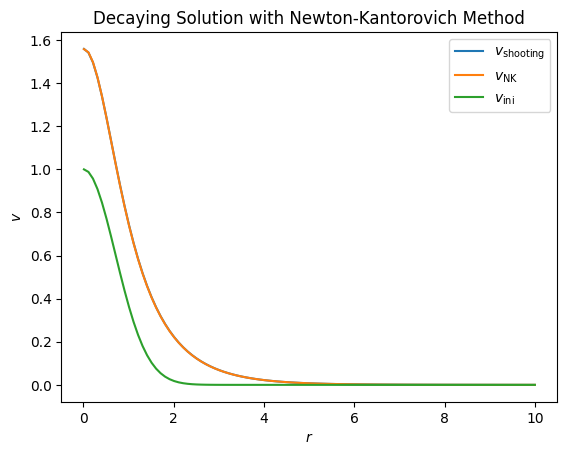

In [27]:
plt.plot(r, v1, label=r'$v_\mathrm{shooting}$')
plt.plot(r, v, label=r'$v_\mathrm{NK}$')
plt.plot(r, v_ini, label=r'$v_\mathrm{ini}$')
plt.xlabel(r'$r$')
plt.ylabel(r'$v$')
plt.title(r'Decaying Solution with Newton-Kantorovich Method')
plt.legend()
plt.show()